# Importing Packages

In [7]:
# Installing Packages
!{sys.executable} -m pip install nba_api --quiet
!{sys.executable} -m pip install pandas --quiet
!{sys.executable} -m pip install tqdm --quiet

#Importing packages
from nba_api.stats.static import players
from nba_api.stats.endpoints import leaguegamefinder
from nba_api.stats.endpoints import commonplayerinfo
from nba_api.stats.endpoints import playbyplayv2
import requests, pandas as pd, sys
from tqdm import tqdm
import dateutil.parser as parser
import numpy as np
import time
import seaborn as sns
from datetime import datetime,  timedelta


[notice] A new release of pip available: 22.3.1 -> 23.0
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip available: 22.3.1 -> 23.0
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip available: 22.3.1 -> 23.0
[notice] To update, run: pip install --upgrade pip


# Setting Pandas option to show all columns

In [8]:
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
pd.set_option('display.max_rows', 25)

# Creating Function for API pull

### Setting parameters for data pull

In [9]:
#Creating header var for api pull
headers: dict[str, str]  = {
    'Connection': 'keep-alive',
    'Accept': 'application/json, text/plain, */*',
    'x-nba-stats-token': 'true',
    'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_6) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/79.0.3945.130 Safari/537.36',
    'x-nba-stats-origin': 'stats',
    'Sec-Fetch-Site': 'same-origin',
    'Sec-Fetch-Mode': 'cors',
    'Referer': 'https://stats.nba.com/',
    'Accept-Encoding': 'gzip, deflate, br',
    'Accept-Language': 'en-US,en;q=0.9',
}

### Function that Pulls API data

In [10]:
# create function that gets pbp (play by play) logs from the 2021-22 season
def get_data(game_id) -> pd.DataFrame:
    play_by_play_url = "https://cdn.nba.com/static/json/liveData/playbyplay/playbyplay_"+game_id+".json"
    response = requests.get(url=play_by_play_url, headers=headers).json()
    play_by_play = response['game']['actions']
    df = pd.DataFrame(play_by_play)
    df['gameid'] = game_id
    return df

### Defining parameters for data pull

In [11]:
gamefinder = leaguegamefinder.LeagueGameFinder(season_nullable='2021-22',
                                               league_id_nullable='00',
                                               season_type_nullable='Regular Season')

## Retrieving Game Ids

## List of unique game ids for 2021-2022 season

In [12]:
# Retrieving all game dataframes to get unique game ids
games = gamefinder.get_data_frames()[0]

#getting a list of distinct game ids
game_ids = games['GAME_ID'].unique()

# Setting an empty list for the game information
pbpdata = []

#Here TDQM() creates a % completion bar
for game_id in tqdm(game_ids):
    game_data: pd.DataFrame = get_data(game_id)
    pbpdata.append(game_data)

final_df: pd.DataFrame = pd.concat(pbpdata, ignore_index=True)

100%|██████████| 1230/1230 [05:18<00:00,  3.86it/s]


In [13]:
print(len(final_df))
print(len(final_df['gameid'].unique()))

691875
1230


# Instantiating Data Frame

In [14]:
final_df_copy: pd.DataFrame = pd.DataFrame(final_df)

## Reviewing Column Names

In [15]:
#Primary columns in the DF
final_df_copy.columns

Index(['actionNumber', 'clock', 'timeActual', 'period', 'periodType', 'actionType', 'subType', 'qualifiers', 'personId', 'x', 'y', 'possession', 'scoreHome', 'scoreAway', 'edited', 'orderNumber', 'xLegacy', 'yLegacy', 'isFieldGoal', 'side', 'description', 'personIdsFilter', 'teamId', 'teamTricode', 'descriptor', 'jumpBallRecoveredName', 'jumpBallRecoverdPersonId', 'playerName', 'playerNameI', 'jumpBallWonPlayerName', 'jumpBallWonPersonId', 'jumpBallLostPlayerName', 'jumpBallLostPersonId', 'shotDistance', 'shotResult', 'shotActionNumber', 'reboundTotal', 'reboundDefensiveTotal', 'reboundOffensiveTotal', 'pointsTotal', 'assistPlayerNameInitial', 'assistPersonId', 'assistTotal', 'officialId', 'foulPersonalTotal', 'foulTechnicalTotal', 'foulDrawnPlayerName', 'foulDrawnPersonId', 'turnoverTotal', 'blockPlayerName', 'blockPersonId', 'stealPlayerName', 'stealPersonId', 'value', 'gameid'], dtype='object')

In [16]:
final_df_copy.head()

,actionNumber,clock,timeActual,period,periodType,actionType,subType,qualifiers,personId,x,y,possession,scoreHome,scoreAway,edited,orderNumber,xLegacy,yLegacy,isFieldGoal,side,description,personIdsFilter,teamId,teamTricode,descriptor,jumpBallRecoveredName,jumpBallRecoverdPersonId,playerName,playerNameI,jumpBallWonPlayerName,jumpBallWonPersonId,jumpBallLostPlayerName,jumpBallLostPersonId,shotDistance,shotResult,shotActionNumber,reboundTotal,reboundDefensiveTotal,reboundOffensiveTotal,pointsTotal,assistPlayerNameInitial,assistPersonId,assistTotal,officialId,foulPersonalTotal,foulTechnicalTotal,foulDrawnPlayerName,foulDrawnPersonId,turnoverTotal,blockPlayerName,blockPersonId,stealPlayerName,stealPersonId,value,gameid
0,2,PT12M00.00S,2022-04-10T19:40:56.4Z,1,REGULAR,period,start,[],0,NaN,NaN,0,0,0,2022-04-10T19:40:56Z,20000,NaN,NaN,0,None,Period Start,[],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0022101221
1,4,PT11M56.00S,2022-04-10T19:41:00.0Z,1,REGULAR,jumpball,recovered,[],1628989,NaN,NaN,1610612737,0,0,2022-04-10T19:41:00Z,40000,NaN,NaN,0,None,Jump Ball C. Capela vs. A. Sengun: Tip to K. H...,"[1628989, 203991, 1630578]",1.610613e+09,ATL,startperiod,K. Huerter,1628989.0,Huerter,K. Huerter,Capela,203991.0,Sengun,1630578.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0022101221
2,7,PT11M43.00S,2022-04-10T19:41:13.1Z,1,REGULAR,3pt,Jump Shot,[],1628989,7.178055,4.656863,1610612737,0,0,2022-04-10T19:41:20Z,70000,227.0,15.0,1,left,MISS K. Huerter 3PT,[1628989],1.610613e+09,ATL,NaN,NaN,NaN,Huerter,K. Huerter,NaN,NaN,NaN,NaN,22.72,Missed,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0022101221
3,8,PT11M40.00S,2022-04-10T19:41:16.1Z,1,REGULAR,rebound,defensive,[],1629726,NaN,NaN,1610612745,0,0,2022-04-10T19:41:20Z,80000,NaN,NaN,0,None,G. Mathews REBOUND (Off:0 Def:1),[1629726],1.610613e+09,HOU,NaN,NaN,NaN,Mathews,G. Mathews,NaN,NaN,NaN,NaN,NaN,NaN,7.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0022101221
4,9,PT11M29.00S,2022-04-10T19:41:26.0Z,1,REGULAR,3pt,Jump Shot,[],1629726,66.442181,56.372549,1610612745,3,0,2022-04-10T19:41:30Z,90000,32.0,263.0,1,right,G. Mathews 26' 3PT (3 PTS) (A. Sengun 1 AST),"[1629726, 1630578]",1.610613e+09,HOU,NaN,NaN,NaN,Mathews,G. Mathews,NaN,NaN,NaN,NaN,26.48,Made,NaN,NaN,NaN,NaN,3.0,A. Sengun,1630578.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0022101221


In [17]:
final_df_copy.describe()

,actionNumber,period,personId,x,y,possession,orderNumber,xLegacy,yLegacy,isFieldGoal,teamId,jumpBallRecoverdPersonId,jumpBallWonPersonId,jumpBallLostPersonId,shotDistance,shotActionNumber,reboundTotal,reboundDefensiveTotal,reboundOffensiveTotal,pointsTotal,assistPersonId,assistTotal,officialId,foulPersonalTotal,foulTechnicalTotal,foulDrawnPersonId,turnoverTotal,blockPersonId,stealPersonId
count,691875.000000,691875.000000,6.918750e+05,216713.000000,216713.000000,6.918750e+05,6.918750e+05,216713.000000,216713.000000,691875.000000,6.650260e+05,2.087000e+03,2.183000e+03,2.183000e+03,216713.000000,128907.000000,109347.000000,109347.000000,109347.000000,141587.000000,6.063600e+04,60636.000000,6.832800e+04,49746.000000,49746.000000,4.830600e+04,32102.000000,1.160300e+04,1.876000e+04
mean,338.339700,2.547697,1.031516e+06,49.968831,49.575517,1.604646e+09,3.322918e+06,-2.716113,96.808876,0.313226,1.610613e+09,1.116123e+06,1.029718e+06,1.110913e+06,14.284271,329.759261,4.023192,3.071653,0.951540,9.896961,1.092272e+06,3.094878,4.515309e+05,1.995055,0.062156,1.095785e+06,1.905613,1.144186e+06,1.155470e+06
std,194.280636,1.128020,7.275118e+05,35.589950,22.923325,9.784667e+07,1.906753e+06,114.604103,95.291674,0.463806,8.643626e+00,6.896156e+05,7.075713e+05,6.887543e+05,10.578877,196.023594,3.070912,2.462871,1.269107,7.440506,6.947680e+05,2.405318,6.427159e+05,1.130653,0.252112,6.935572e+05,1.214381,6.794527e+05,6.751063e+05
min,2.000000,1.000000,0.000000e+00,0.213535,0.000000,0.000000e+00,2.000000e+04,-250.000000,-51.000000,0.000000,1.610613e+09,2.544000e+03,2.544000e+03,2.544000e+03,0.000000,3.000000,1.000000,0.000000,0.000000,1.000000,2.544000e+03,1.000000,1.146000e+03,0.000000,0.000000,2.544000e+03,1.000000,2.544000e+03,2.544000e+03
25%,170.000000,2.000000,2.030760e+05,11.563732,39.460784,1.610613e+09,1.680000e+06,-53.000000,14.000000,0.000000,1.610613e+09,2.032000e+05,2.035000e+05,2.035165e+05,3.140000,160.000000,2.000000,1.000000,0.000000,4.000000,2.034630e+05,1.000000,2.005000e+03,1.000000,0.000000,2.034960e+05,1.000000,2.034970e+05,2.035010e+05
50%,336.000000,3.000000,1.627759e+06,57.506570,50.000000,1.610613e+09,3.300000e+06,0.000000,57.000000,0.000000,1.610613e+09,1.628366e+06,1.626174e+06,1.627745e+06,13.940000,329.000000,3.000000,2.000000,1.000000,8.000000,1.627826e+06,2.000000,2.016400e+05,2.000000,0.000000,1.627814e+06,1.000000,1.628381e+06,1.628374e+06
75%,503.000000,4.000000,1.629632e+06,88.354139,59.068627,1.610613e+09,4.940000e+06,47.000000,184.000000,1.000000,1.610613e+09,1.629632e+06,1.629011e+06,1.629603e+06,25.080000,496.000000,5.000000,4.000000,1.000000,14.000000,1.629636e+06,4.000000,2.040580e+05,3.000000,0.000000,1.629630e+06,2.000000,1.629647e+06,1.629655e+06
max,893.000000,7.000000,1.630994e+06,99.819317,99.754902,1.610613e+09,8.750000e+06,250.000000,878.000000,1.000000,1.610613e+09,1.630787e+06,1.630846e+06,1.630846e+06,88.940000,890.000000,25.000000,21.000000,12.000000,60.000000,1.630994e+06,19.000000,1.629422e+06,6.000000,3.000000,1.630994e+06,10.000000,1.630846e+06,1.630994e+06


# _Data Manipulation and Formating_

### Checking data types

In [18]:
### Transforming data types
dict(final_df_copy.dtypes)

{'actionNumber': dtype('int64'),
 'clock': dtype('O'),
 'timeActual': dtype('O'),
 'period': dtype('int64'),
 'periodType': dtype('O'),
 'actionType': dtype('O'),
 'subType': dtype('O'),
 'qualifiers': dtype('O'),
 'personId': dtype('int64'),
 'x': dtype('float64'),
 'y': dtype('float64'),
 'possession': dtype('int64'),
 'scoreHome': dtype('O'),
 'scoreAway': dtype('O'),
 'edited': dtype('O'),
 'orderNumber': dtype('int64'),
 'xLegacy': dtype('float64'),
 'yLegacy': dtype('float64'),
 'isFieldGoal': dtype('int64'),
 'side': dtype('O'),
 'description': dtype('O'),
 'personIdsFilter': dtype('O'),
 'teamId': dtype('float64'),
 'teamTricode': dtype('O'),
 'descriptor': dtype('O'),
 'jumpBallRecoveredName': dtype('O'),
 'jumpBallRecoverdPersonId': dtype('float64'),
 'playerName': dtype('O'),
 'playerNameI': dtype('O'),
 'jumpBallWonPlayerName': dtype('O'),
 'jumpBallWonPersonId': dtype('float64'),
 'jumpBallLostPlayerName': dtype('O'),
 'jumpBallLostPersonId': dtype('float64'),
 'shotDistan

## Time Conversion Functions
### Creating columns for "Time Passed in Game" and "Date of Game"
### "Time Passed in Game" = the total time passed within a game (Format: Min:Sec)
### "Date of Game" = The minimum dte that a game started on (if a game starts on 04/05/22 and goes into 04/06/23 the game started on 04/05/23)

In [19]:
# creating a date column
final_df_copy['dateGameStarted'] = pd.to_datetime(final_df_copy.timeActual).dt.date

# Need to use columns:  Period and Clock to determine what time in the game it is (Clock counts down per period)
# period_to_total_time 

# create a fucntion and use map to apply it to the new column

def period_to_time_conversion(value) -> int:

    if value == 1:
        return 0
    elif value == 2:
        return 12
    elif value == 3:
        return 24
    else:
        return 36


def time_conversion(unparsed_timearray):
    x = datetime(year =1900, month=1, day=1, hour=0, minute=12, second=0)
    values_array = unparsed_timearray[0:7]
    time_passed_total = x - pd.to_datetime(values_array, format='PT%MM%S')
    return time_passed_total


# Creating a function to create new column with total time passed in game
def total_time_passed(period_finished_minutes, minutes_passed_within_period):
    period_minutes = pd.to_datetime(period_finished_minutes, format='%M')
    minutes_within_period = minutes_passed_within_period
    return period_minutes + minutes_within_period

In [20]:
final_df_copy['period_to_time'] = final_df_copy['period'].map(period_to_time_conversion)
final_df_copy['time_passed_in_seconds'] = final_df_copy['clock'].map(time_conversion)
final_df_copy['Total_time_passed_in_game'] = list(map(total_time_passed, final_df_copy.period_to_time, final_df_copy.time_passed_in_seconds))

### Creating a new data fame with players removed if they do not pass conditions:
-  play atleast 20 games AND have more than 10 combined PTS/REB/AST avg per game

In [21]:
player_games_played: pd.DataFrame = final_df_copy[['gameid','playerNameI', 'personId']].groupby(['personId', 'playerNameI'], as_index=False).nunique().sort_values('gameid', ascending=False)
players_with_20more_games = player_games_played[player_games_played.gameid >= 20].personId

player_stats_threshold: pd.DataFrame = final_df_copy[['gameid','playerNameI', 'personId', 'pointsTotal', 'assistTotal', 'reboundTotal']].groupby(['personId', 'playerNameI', 'gameid'], as_index=False).max().sort_values('gameid', ascending=False)
player_stats_threshold['combined_totals'] = player_stats_threshold.iloc[:, 3:].sum(axis=1)
player_stats_threshold_avgs = player_stats_threshold.groupby(['personId', 'playerNameI'], as_index=False)['combined_totals'].mean()
player_stats_threshold_id_list = player_stats_threshold_avgs[player_stats_threshold_avgs.combined_totals >= 10]

joined_player_id_list = pd.merge(player_stats_threshold_id_list, players_with_20more_games, how='inner', on=['personId']).personId

### Creating New DF with only players 20 games+ and 10 total points/rbs/assists avg per game

In [22]:
df_players_removed: pd.DataFrame = final_df_copy.query('personId in @joined_player_id_list')

### Preping a mapping dict for player names and Player Ids

In [23]:
#Changing column to int data type
df_players_removed.assistPersonId = final_df_copy.assistPersonId.astype('Int64')

# Creating a dict for mapping object of names and ids
playerid_and_player_initials_dict_assists =dict(zip(df_players_removed.assistPlayerNameInitial.values, df_players_removed.assistPersonId))
playerid_and_player_initials_dict_playername_to_personid =dict(zip(df_players_removed.playerNameI.values, df_players_removed.personId))
playerid_and_player_initials_dict_combined = playerid_and_player_initials_dict_assists | playerid_and_player_initials_dict_playername_to_personid

/var/folders/_l/4wqjn4456n15dy3l1xmxt0nh0000gn/T/ipykernel_99442/4111727379.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_players_removed.assistPersonId = final_df_copy.assistPersonId.astype('Int64')


# Data Frame Fuctions
### Creating TS% (true shooting percetage) data frames

In [24]:
def ts_perc_dataframe_creation(input_dataframe: pd.DataFrame)-> pd.DataFrame:        
        
        df_most_info: pd.DataFrame = input_dataframe\
                .groupby(['playerNameI','gameid', 'personId'], as_index=False)\
                .agg({'isFieldGoal':np.sum,\
                'dateGameStarted':np.min,\
                'pointsTotal': np.max,})

        df_fta = input_dataframe[ ((input_dataframe.actionType == 'freethrow'))]\
                .groupby(['playerNameI','personId','gameid', 'actionType'], as_index=False)['actionType'].count()
                # .agg({'actionType': 'sum'})

        #Merging DFs on columns gameid and playernamei
        combined_df_all_metrics: pd.DataFrame = pd.merge(df_most_info, df_fta, how='left', on=['personId','playerNameI','gameid'])

        # Renaming Column Names
        combined_df_all_metrics = combined_df_all_metrics.rename(columns={'isFieldGoal':'FGA', 'actionType':'FTA'})

        # Moving columns to a better order
        cols: list[str] = ['dateGameStarted', 'gameid', 'playerNameI', 'pointsTotal', 'FGA', 'FTA']
        combined_df_all_metrics = combined_df_all_metrics[cols]

        # Replacing Nans in the DF with 0s
        combined_df_all_metrics =combined_df_all_metrics.fillna(0)

        # Creating TS% column
        combined_df_all_metrics['TS%'] = round((combined_df_all_metrics['pointsTotal'])/\
                        (2*((combined_df_all_metrics['FGA'])+ (combined_df_all_metrics['FTA']*.44))) * 100,3)
        
        return combined_df_all_metrics

In [25]:
df_groupby = ts_perc_dataframe_creation(df_players_removed)

In [26]:
df_groupby

,dateGameStarted,gameid,playerNameI,pointsTotal,FGA,FTA,TS%
0,2021-10-20,0022100002,A. Bradley,6.0,3,0.0,100.000
1,2021-10-23,0022100025,A. Bradley,0.0,3,0.0,0.000
2,2021-10-25,0022100040,A. Bradley,0.0,0,0.0,NaN
3,2021-10-28,0022100061,A. Bradley,13.0,7,0.0,92.857
4,2021-10-30,0022100077,A. Bradley,7.0,5,0.0,70.000
...,...,...,...,...,...,...,...
20852,2022-04-02,0022101155,Z. Williams,19.0,15,4.0,56.683
20853,2022-04-06,0022101187,Z. Williams,9.0,6,4.0,57.990
20854,2022-04-08,0022101201,Z. Williams,12.0,8,2.0,67.568
20855,2022-04-09,0022101213,Z. Williams,19.0,12,3.0,71.321


In [27]:
df_groupby.sort_values(['TS%'], ascending=False).head()

#### Some of these dates are reflective of when the games actuallt occured
# Alex len, Zeke Nnaji

,dateGameStarted,gameid,playerNameI,pointsTotal,FGA,FTA,TS%
10022,2022-03-13,0022101010,J. Holiday,3.0,1,0.0,150.0
13994,2021-12-14,0022100404,L. Stevens,3.0,1,0.0,150.0
15456,2021-11-07,0022100141,M. Wagner,3.0,1,0.0,150.0
10343,2022-03-19,0022101047,J. Konchar,3.0,1,0.0,150.0
10334,2022-02-17,0022100879,J. Konchar,3.0,1,0.0,150.0


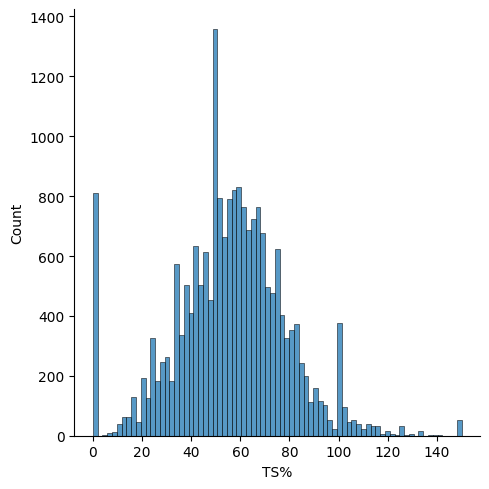

In [28]:
# Plotting distribution of TS%s of all players in the 2021-2022 season
sns.displot(df_groupby, x='TS%');

In [29]:
def ts_perc_dataframe_creation_whole_season(input_dataframe: pd.DataFrame)-> pd.DataFrame:
        
        df_most_info = input_dataframe\
                .groupby(['playerNameI', 'personId'], as_index=False)\
                .agg({'isFieldGoal':np.sum,\
                        'shotDistance':np.sum})

        df_points_per_game = input_dataframe\
                .groupby(['playerNameI','gameid', 'personId'], as_index=False)\
                .agg({'pointsTotal': np.max,})
        
        df_points_seaon_totals = df_points_per_game\
                .groupby(['playerNameI','personId'], as_index=False)\
                .agg({'pointsTotal': np.sum,})

        df_fta = input_dataframe[ ((input_dataframe.actionType == 'freethrow'))]\
                .groupby(['playerNameI','personId', 'actionType'], as_index=False)['actionType'].count()

        # Merging most and total_points
        df_points_and_most = pd.merge(df_most_info, df_points_seaon_totals, how='inner', on=['personId','playerNameI',])

        #Merging DFs on columns playernamei and personId
        combined_df_all_metrics_season = pd.merge(df_points_and_most, df_fta, how='left', on=['personId','playerNameI',])

        # Renaming Column Names
        combined_df_all_metrics_season = combined_df_all_metrics_season.rename(columns={'isFieldGoal':'FGA', 'actionType':'FTA'})

        # Moving columns to a better order
        cols: list[str] = ['playerNameI', 'pointsTotal', 'FGA', 'FTA', 'shotDistance']
        combined_df_all_metrics_season = combined_df_all_metrics_season[cols]

        # Replacing Nans in the DF with 0s
        combined_df_all_metrics_season =combined_df_all_metrics_season.fillna(0)

        # Creating TS% column
        combined_df_all_metrics_season['TS%'] = round((combined_df_all_metrics_season['pointsTotal'])/\
                        (2*((combined_df_all_metrics_season['FGA'])+ (combined_df_all_metrics_season['FTA']*.44))) * 100,3)

        combined_df_all_metrics_season['avg_shot_distance'] = round(combined_df_all_metrics_season.shotDistance/combined_df_all_metrics_season.FGA,3)
        
        return combined_df_all_metrics_season

In [30]:
df_groupby_season = ts_perc_dataframe_creation_whole_season(df_players_removed)

In [31]:
df_groupby_season
# Alecburks maching ts%!
# So does davis

,playerNameI,pointsTotal,FGA,FTA,shotDistance,TS%,avg_shot_distance
0,A. Bradley,394.0,350,18,6317.45,55.040,18.050
1,A. Burks,944.0,728,264,12635.16,55.914,17.356
2,A. Caruso,304.0,257,73,3992.20,52.573,15.534
3,A. Coffey,619.0,466,117,7817.39,59.809,16.776
4,A. Davis,927.0,695,244,6686.61,57.767,9.621
...,...,...,...,...,...,...,...
342,X. Tillman,252.0,216,71,2064.39,50.963,9.557
343,Z. Collins,218.0,155,65,1711.84,59.368,11.044
344,Z. LaVine,1635.0,1185,375,18060.08,60.556,15.241
345,Z. Nnaji,270.0,186,65,2430.48,62.908,13.067


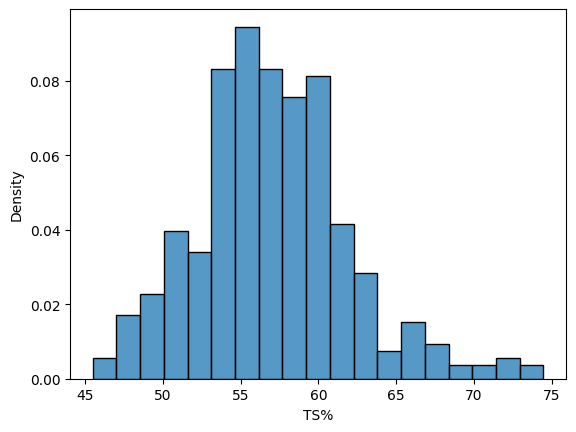

In [36]:
from scipy import stats                           
# Data
seaborn_plot = sns.histplot(df_groupby_season['TS%'], label='samples', stat='density')

#prob dens function
# x0, x1 = seaborn_plot.get_xlim()
# xpdf = np.linspace(x0, x1, 100)
# ypdf = stats.norm.pdf(xpdf)
# seaborn_plot.plot(xpdf, label='pdf' )
# seaborn_plot.legend();

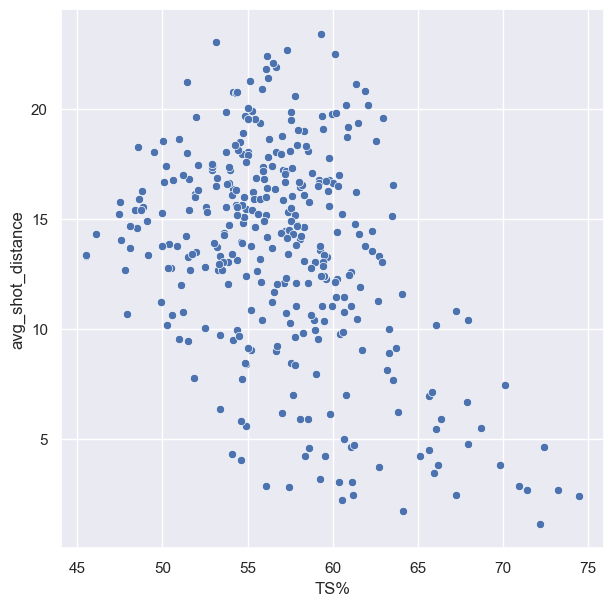

In [37]:
# Map TS% and average distance per shot for the whole season
sns.set(rc={'figure.figsize':(7,7)})
sns.scatterplot(df_groupby_season, x='TS%', y='avg_shot_distance');


## Analyzing % of shots missed and made by distance

In [38]:
# Creating 2 distributions of shots made from distance and shots missed from distance
# final_df_copy.shotDistance = final_df_copy.shotDistance.round(1)
df_shot_made = final_df_copy[((final_df_copy.actionType != 'freethrow') & (final_df_copy.shotResult == 'Made'))][['shotDistance', 'shotResult', 'actionType']]
df_shot_missed = final_df_copy[((final_df_copy.actionType != 'freethrow') & (final_df_copy.shotResult == 'Missed'))][['shotDistance', 'shotResult', 'actionType']]
df_shots_combined = pd.concat([df_shot_made, df_shot_missed])
df_shots_combined = df_shots_combined[df_shots_combined.shotDistance <= 46.0]

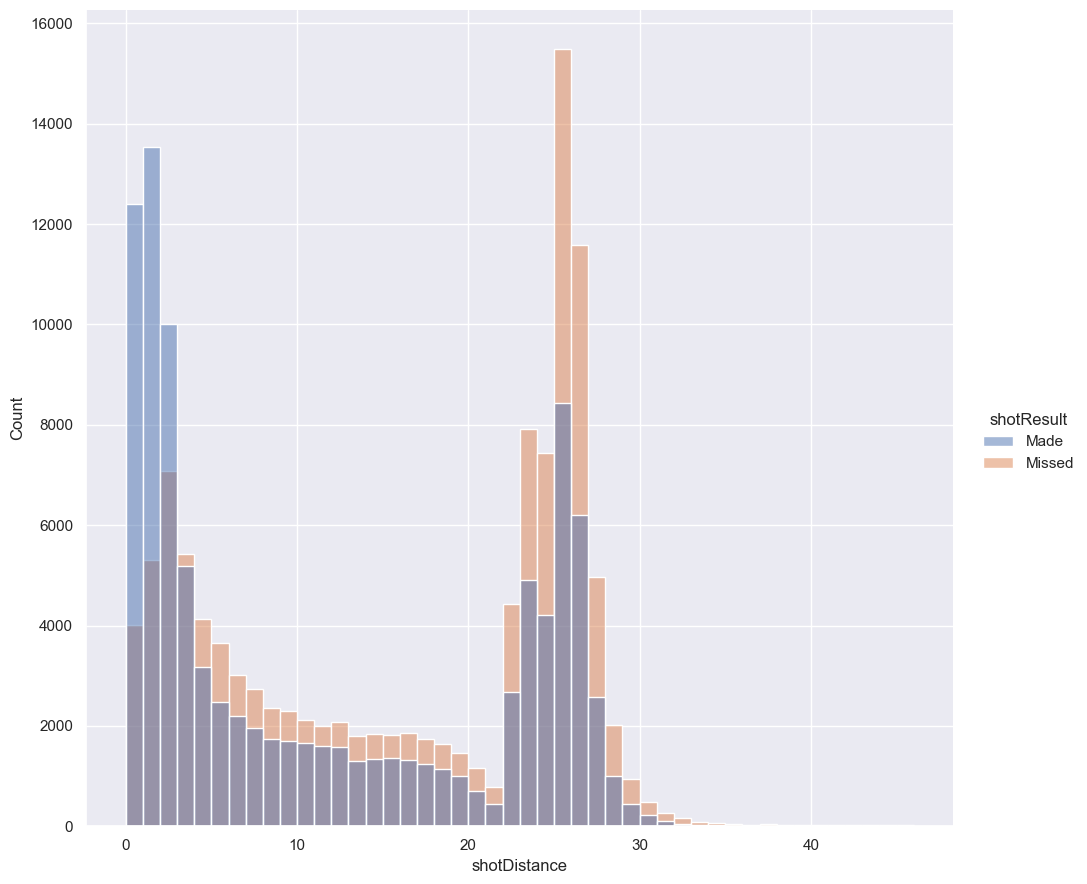

In [39]:
sns.set(rc={'figure.figsize':(5,5)})
sns.displot(df_shots_combined,x='shotDistance', binwidth=1, hue='shotResult', height=9, aspect=1.10);

# Get x axis to show ticks every 2 feet

## Analyzing Best players in the clutch
### % of team points and total points in clutch
#### Clutch is defined as games where teams are within 5 points under 5 minutes remaining

In [68]:
df_clutch = final_df_copy
# creating a date column
df_clutch['dateGameStarted'] = pd.to_datetime(df_clutch.timeActual).dt.date

df_clutch['period_to_time'] = df_clutch['period'].map(period_to_time_conversion)    

df_clutch['time_passed_in_seconds'] = df_clutch['clock'].map(time_conversion)

df_clutch['Total_time_passed_in_game'] = list(map(total_time_passed, df_clutch.period_to_time, df_clutch.time_passed_in_seconds))

In [69]:
df_clutch = df_clutch.astype({'scoreHome': 'int64', 'scoreAway':'int64'})

In [70]:
df_clutch_final = df_clutch[(df_clutch['Total_time_passed_in_game'] >='1900-01-01 00:43:00' ) &\
                                     (abs(df_clutch['scoreHome']- df_clutch['scoreAway']) <= 5)]

In [93]:
df_clutch_final.head()

,actionNumber,clock,timeActual,period,periodType,actionType,subType,qualifiers,personId,x,y,possession,scoreHome,scoreAway,edited,orderNumber,xLegacy,yLegacy,isFieldGoal,side,description,personIdsFilter,teamId,teamTricode,descriptor,jumpBallRecoveredName,jumpBallRecoverdPersonId,playerName,playerNameI,jumpBallWonPlayerName,jumpBallWonPersonId,jumpBallLostPlayerName,jumpBallLostPersonId,shotDistance,shotResult,shotActionNumber,reboundTotal,reboundDefensiveTotal,reboundOffensiveTotal,pointsTotal,assistPlayerNameInitial,assistPersonId,assistTotal,officialId,foulPersonalTotal,foulTechnicalTotal,foulDrawnPlayerName,foulDrawnPersonId,turnoverTotal,blockPlayerName,blockPersonId,stealPlayerName,stealPersonId,value,gameid,dateGameStarted,period_to_time,time_passed_in_seconds,Total_time_passed_in_game
2188,616,PT04M29.00S,2022-04-11T02:46:53.8Z,4,REGULAR,freethrow,2 of 2,[],1630195,NaN,NaN,1610612750,106,111,2022-04-11T02:46:53Z,6080000,NaN,NaN,0,None,L. Bolmaro Free Throw 2 of 2 (9 PTS),[1630195],1.610613e+09,MIN,NaN,NaN,NaN,Bolmaro,L. Bolmaro,NaN,NaN,NaN,NaN,NaN,Made,NaN,NaN,NaN,NaN,9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0022101224,2022-04-11,36,0 days 00:07:31,1900-01-01 00:43:31
2189,617,PT04M14.00S,2022-04-11T02:47:11.2Z,4,REGULAR,2pt,Jump Shot,[],1630245,78.531537,61.764706,1610612741,106,111,2022-04-11T02:47:16Z,6090000,59.0,149.0,1,right,MISS A. Dosunmu 16' pullup Shot,[1630245],1.610613e+09,CHI,pullup,NaN,NaN,Dosunmu,A. Dosunmu,NaN,NaN,NaN,NaN,16.05,Missed,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0022101224,2022-04-11,36,0 days 00:07:46,1900-01-01 00:43:46
2190,618,PT04M11.00S,2022-04-11T02:47:14.2Z,4,REGULAR,rebound,offensive,[],1627884,NaN,NaN,1610612741,106,111,2022-04-11T02:47:16Z,6100000,NaN,NaN,0,None,D. Jones Jr. REBOUND (Off:3 Def:1),[1627884],1.610613e+09,CHI,NaN,NaN,NaN,Jones Jr.,D. Jones Jr.,NaN,NaN,NaN,NaN,NaN,NaN,617.0,4.0,1.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0022101224,2022-04-11,36,0 days 00:07:49,1900-01-01 00:43:49
2191,619,PT04M05.00S,2022-04-11T02:47:20.5Z,4,REGULAR,2pt,Jump Shot,[2ndchance],1630172,74.063732,45.098039,1610612741,106,111,2022-04-11T02:47:25Z,6110000,-25.0,191.0,1,right,MISS P. Williams 19' pullup Shot - blocked,"[1630172, 1629006]",1.610613e+09,CHI,pullup,NaN,NaN,Williams,P. Williams,NaN,NaN,NaN,NaN,19.29,Missed,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Okogie,1629006.0,NaN,NaN,NaN,0022101224,2022-04-11,36,0 days 00:07:55,1900-01-01 00:43:55
2192,620,PT04M05.00S,2022-04-11T02:47:20.5Z,4,REGULAR,block,NaN,[],1629006,NaN,NaN,1610612741,106,111,2022-04-11T02:47:23Z,6120000,NaN,NaN,0,None,J. Okogie BLOCK (1 BLK),[1629006],1.610613e+09,MIN,NaN,NaN,NaN,Okogie,J. Okogie,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0022101224,2022-04-11,36,0 days 00:07:55,1900-01-01 00:43:55


In [74]:
df_clutch_final[df_clutch_final['shotResult']=='Made']['actionType'].unique()

array(['freethrow', '2pt', '3pt'], dtype=object)

In [146]:
# Build out another column for each point scored per team
def score_per_shot_type(df) -> int:
    if (df['shotResult'] == 'Made') & (df['actionType'] == 'freethrow'):
        return 1
    elif (df['shotResult'] == 'Made') & (df['actionType'] == '2pt'):
        return 2
    elif (df['shotResult'] == 'Made') & (df['actionType'] == '3pt'):
        return 3
    else:
        return 0

In [147]:
df_clutch_final['score_value'] = df_clutch_final.apply(score_per_shot_type, axis=1)

/var/folders/_l/4wqjn4456n15dy3l1xmxt0nh0000gn/T/ipykernel_99442/3577904395.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clutch_final['score_value'] = df_clutch_final.apply(score_per_shot_type, axis=1)


In [167]:
# Get each teams total points scored in the clutch for the entire season
sum_total_points_in_clutch = df_clutch_final.groupby(['teamTricode', 'teamId']).agg({'score_value':np.sum}).reset_index()

In [170]:
sum_total_points_per_player = df_clutch_final.groupby(['teamTricode', 'teamId', 'personId', 'playerNameI']).agg({'score_value':np.sum}).reset_index()

In [175]:
combined_players_teams_points = sum_total_points_per_player.merge(sum_total_points_in_clutch,how='left', on=['teamTricode', 'teamId'], suffixes=('player_points', 'team_points'))
combined_players_teams_points['percentage_of_teams_total_clutch_points'] = round(combined_players_teams_points['score_valueplayer_points']/combined_players_teams_points['score_valueteam_points']*100,2)

In [181]:
combined_players_teams_points[combined_players_teams_points.percentage_of_teams_total_clutch_points > 30].sort_values('percentage_of_teams_total_clutch_points', ascending=False)

,teamTricode,teamId,personId,playerNameI,score_valueplayer_points,score_valueteam_points,percentage_of_teams_total_clutch_points
260,MEM,1.610613e+09,1629630,J. Morant,107,260,41.15
11,ATL,1.610613e+09,1629027,T. Young,118,291,40.55
129,DEN,1.610613e+09,203999,N. Jokic,147,371,39.62
70,CHI,1.610613e+09,201942,D. DeRozan,141,360,39.17
400,PHI,1.610613e+09,203954,J. Embiid,150,399,37.59
472,SAS,1.610613e+09,1627749,D. Murray,111,331,33.53
387,ORL,1.610613e+09,1630175,C. Anthony,87,280,31.07
305,MIN,1.610613e+09,1626156,D. Russell,80,263,30.42
121,DAL,1.610613e+09,1629029,L. Doncic,81,268,30.22


In [ ]:
#Notes for to dos for this data set
# --What duo had the most assits to dunks in the NBA
# --best assist to turn over ratio
# -- distribution of made shots per team
# do one of those attribute hexagon charts where I plot 3pt, 2pt (type of 2 pt), and free throw % of each team


# Done---------------->
# --Calculate true shooting % of all players? using apply? or creating a function... probably this
#     #TS% - True Shooting Percentage; the formula is PTS / (2 * TSA). True shooting percentage is a measure of shooting efficiency that takes into account field goals, 3-point field goals, and free throws.
#     #TSA - True Shooting Attempts; the formula is FGA + 0.44 * FTA.

# --Look at % of makes of shots based on distance



#############################################################################
# """
# Add Stats around TS and other stats like variability and a distribution curve
# Plot it againts league average 
# Grab players that exhibit the most varibaility or the least
# """
#############################################################################

## THIS IS ANALYSIS

In [ ]:
#Looking at shots taken from rounded distances
final_df_copy.loc[:,['shotDistance']].round().value_counts()#.sort_index()

shotDistance
26.0            22892
2.0             19249
25.0            18937
1.0             16445
3.0             13577
                ...  
82.0                1
83.0                1
84.0                1
88.0                1
89.0                1
Length: 87, dtype: int64

In [ ]:
#breaking down shot distance and the % of total shots made from the distance
final_df_copy.loc[:, ['shotResult']].value_counts()

shotResult
Made          141587
Missed        128907
dtype: int64

In [ ]:
final_df_copy['actionType'].unique()

array(['period', 'jumpball', '2pt', 'block', 'rebound', '3pt', 'timeout',
       'turnover', 'steal', 'foul', 'instantreplay', 'freethrow',
       'stoppage', 'substitution', 'violation', 'game', 'ejection',
       'memo'], dtype=object)

In [ ]:
#pulling rows where actionType = 'block'
final_df_copy[final_df_copy.actionType == 'block']

,actionNumber,clock,timeActual,period,periodType,actionType,subType,qualifiers,personId,x,y,possession,scoreHome,scoreAway,edited,orderNumber,xLegacy,yLegacy,isFieldGoal,side,description,personIdsFilter,teamId,teamTricode,descriptor,jumpBallRecoveredName,jumpBallRecoverdPersonId,playerName,playerNameI,jumpBallWonPlayerName,jumpBallWonPersonId,jumpBallLostPlayerName,jumpBallLostPersonId,shotDistance,shotResult,pointsTotal,assistPlayerNameInitial,assistPersonId,assistTotal,blockPlayerName,blockPersonId,shotActionNumber,reboundTotal,reboundDefensiveTotal,reboundOffensiveTotal,turnoverTotal,stealPlayerName,stealPersonId,officialId,foulPersonalTotal,foulTechnicalTotal,foulDrawnPlayerName,foulDrawnPersonId,value,gameid,dateGameStarted,period_to_time,time_passed_in_seconds,Total_time_passed_in_game
4,10,PT11M14.00S,2022-04-10T19:46:11.9Z,1,REGULAR,block,NaN,[],203083,NaN,NaN,1610612754,2,0,2022-04-10T19:46:14Z,100000,NaN,NaN,0,None,A. Drummond BLOCK (1 BLK),[203083],1.610613e+09,BKN,NaN,NaN,NaN,Drummond,A. Drummond,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0022101216,2022-04-10,0,0 days 00:00:46,1900-01-01 00:00:46
48,65,PT06M28.00S,2022-04-10T19:58:06.4Z,1,REGULAR,block,NaN,[],203083,NaN,NaN,1610612754,18,8,2022-04-10T19:58:11Z,650000,NaN,NaN,0,None,A. Drummond BLOCK (2 BLK),[203083],1.610613e+09,BKN,NaN,NaN,NaN,Drummond,A. Drummond,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0022101216,2022-04-10,0,0 days 00:05:32,1900-01-01 00:05:32
206,253,PT06M23.00S,2022-04-10T20:31:59.4Z,2,REGULAR,block,NaN,[],1630556,NaN,NaN,1610612754,54,42,2022-04-10T20:32:02Z,2480000,NaN,NaN,0,None,K. Edwards BLOCK (1 BLK),[1630556],1.610613e+09,BKN,NaN,NaN,NaN,Edwards,K. Edwards,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0022101216,2022-04-10,12,0 days 00:05:37,1900-01-01 00:17:37
240,291,PT03M54.00S,2022-04-10T20:37:09.7Z,2,REGULAR,block,NaN,[],1630556,NaN,NaN,1610612754,62,48,2022-04-10T20:37:12Z,2860000,NaN,NaN,0,None,K. Edwards BLOCK (2 BLK),[1630556],1.610613e+09,BKN,NaN,NaN,NaN,Edwards,K. Edwards,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0022101216,2022-04-10,12,0 days 00:08:06,1900-01-01 00:20:06
347,425,PT05M45.00S,2022-04-10T21:16:13.6Z,3,REGULAR,block,NaN,[],1628971,NaN,NaN,1610612754,87,84,2022-04-10T21:16:16Z,4180000,NaN,NaN,0,None,B. Brown BLOCK (1 BLK),[1628971],1.610613e+09,BKN,NaN,NaN,NaN,Brown,B. Brown,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0022101216,2022-04-10,24,0 days 00:06:15,1900-01-01 00:30:15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
691748,547,PT09M34.00S,2021-10-20T01:31:36.3Z,4,REGULAR,block,NaN,[],1626192,NaN,NaN,1610612751,99,90,2021-10-20T01:31:39Z,5410000,NaN,NaN,0,None,P. Connaughton BLOCK (1 BLK),[1626192],1.610613e+09,MIL,NaN,NaN,NaN,Connaughton,P. Connaughton,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0022100001,2021-10-20,36,0 days 00:02:26,1900-01-01 00:38:26
691773,578,PT07M46.00S,2021-10-20T01:37:35.2Z,4,REGULAR,block,NaN,[],1629670,NaN,NaN,1610612751,106,93,2021-10-20T01:37:38Z,5680000,NaN,NaN,0,None,J. Nwora BLOCK (1 BLK),[1629670],1.610613e+09,MIL,NaN,NaN,NaN,Nwora,J. Nwora,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0022100001,2021-10-20,36,0 days 00:04:14,1900-01-01 00:40:14
691786,595,PT06M45.00S,2021-10-20T01:40:09.9Z,4,REGULAR,block,NaN,[],203507,NaN,NaN,1610612751,112,95,2021-10-20T01:40:13Z,5850000,NaN,NaN,0,None,G. Antetokounmpo BLOCK (2 BLK),[203507],1.610613e+09,MIL,NaN,NaN,NaN,Antetokounmpo,G. Antetokounmpo,NaN,N

In [ ]:
#take shotDistance, actionType is 2pt and 3pt, shotResult is Missed or Made
all_actions = pd.DataFrame(final_df_copy.loc[:, ["shotDistance", "actionType", "shotResult"]])

In [ ]:
all_actions

,shotDistance,actionType,shotResult
0,NaN,period,NaN
1,NaN,jumpball,NaN
2,0.37,2pt,Made
3,12.92,2pt,Missed
4,NaN,block,NaN
...,...,...,...
691870,NaN,turnover,NaN
691871,29.71,3pt,Missed
691872,NaN,rebound,NaN
691873,NaN,period,NaN


In [ ]:
shots_df = all_actions[(all_actions.shotResult.isin(['Missed', 'Made'])) & (all_actions.actionType.isin(['2pt', '3pt']))]

In [ ]:
shots_df

,shotDistance,actionType,shotResult
2,0.37,2pt,Made
3,12.92,2pt,Missed
6,0.98,2pt,Made
7,26.12,3pt,Missed
9,13.49,2pt,Made
...,...,...,...
691862,6.99,2pt,Missed
691864,0.00,2pt,Missed
691867,1.31,2pt,Made
691868,26.60,3pt,Missed


In [ ]:
shots_df.sort_index(axis = 1, inplace = True)
shots_df = shots_df.round()

/var/folders/_l/4wqjn4456n15dy3l1xmxt0nh0000gn/T/ipykernel_78243/717320966.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  shots_df.sort_index(axis = 1, inplace = True)


In [ ]:
#shots_df.shotResult.replace(['Missed', 0], ['Made', 1])
shots_df['shotResult'] = shots_df.shotResult.replace(['Missed','Made'], [0, 1])

In [ ]:
shots_df.shotResult.value_counts()

0    116783
1     99930
Name: shotResult, dtype: int64

In [ ]:
def percentcalc(x):
    for i in shots_df[shots_df.shotResult]:
        if shots_df[shots_df.shotResult == 'Made']:
            return 1
        else:
            return 0

In [ ]:
# shots_df.map(percentcalc)

In [ ]:
# shots_grouped.shotResult.sum()

## Analyzing what players has the most assits to a dunk 

In [ ]:
#looking into what player has assisted the most dunks in the nba (or per team)
assists = final_df[(final_df.subType == 'DUNK') & (final_df.periodType == 'REGULAR')].loc[:,['assistPlayerNameInitial','playerNameI','teamTricode', 'teamId' ]]

In [ ]:
#adding new col with combined player
assists = assists[pd.notnull(assists.assistPlayerNameInitial)]

In [ ]:
assists['assistor-assiste'] = assists.assistPlayerNameInitial + '  to  ' + assists.playerNameI  

In [ ]:
# assists.columns()

In [ ]:
assistsfinal = assists.loc[: ,['teamTricode','assistor-assiste']].sort_values(by=['teamTricode'])

In [ ]:
assists_grouped = assistsfinal.groupby(['teamTricode','assistor-assiste'])['assistor-assiste'].count()

In [ ]:
assists_grouped

teamTricode  assistor-assiste               
ATL          B. Bogdanovic  to  C. Capela       6
             B. Bogdanovic  to  D. Gallinari    3
             B. Bogdanovic  to  D. Hunter       3
             B. Bogdanovic  to  J. Collins      1
             B. Bogdanovic  to  J. Johnson      1
                                               ..
WAS          T. Satoransky  to  C. Kispert      2
             T. Satoransky  to  D. Gafford      5
             T. Satoransky  to  K. Porzingis    6
             T. Satoransky  to  R. Hachimura    4
             T. Satoransky  to  T. Bryant       1
Name: assistor-assiste, Length: 2570, dtype: int64